In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sim_data import SimData
from collections import Counter
from utils import niceprint

In [2]:
%matplotlib inline

In [3]:
np.random.seed(1)

In [4]:
sim = SimData(
    branching_factors = [3, 3],
    num_docs = 100000,
    doc_length = 2,
    topic_sharpness = 20,
    alpha_leaves = 0.01,
    alpha_depths = 1,
    heavy_words_per_topic = 2,
)

In [5]:
%%time
docs = sim.generate()

CPU times: user 12.7 s, sys: 112 ms, total: 12.8 s
Wall time: 12.8 s


In [6]:
niceprint(sim.topics_by_index)

[[0.2941 0.2941 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147]
 [0.0147 0.0147 0.2941 0.2941 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147]
 [0.0147 0.0147 0.0147 0.0147 0.2941 0.2941 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147]
 [0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.2941 0.2941 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147]
 [0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.2941 0.2941 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147 0.0147

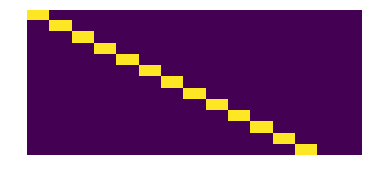

In [7]:
fig, ax = plt.subplots()
ax.imshow(sim.topics_by_index)
ax.axis('off');

In [8]:
num_topics = sim.topics_by_index.shape[0]
count_cooccurrence = np.zeros((num_topics, num_topics))
node_indices = np.array([sim.docs_aux[i]['node_indices_by_word_slot'] for i in range(len(sim.docs_aux))])
for doc_index in range(node_indices.shape[0]):
    i = node_indices[doc_index, 0]
    j = node_indices[doc_index, 1]
    count_cooccurrence[i, j] += 1
coocurrence = count_cooccurrence / np.sum(count_cooccurrence, axis=(0,1))
niceprint(coocurrence)

[[0.1647 0.0280 0.0088 0.0093 0.0090 0.0278 0.0091 0.0092 0.0098 0.0271 0.0097 0.0098 0.0087]
 [0.0270 0.0525 0.0083 0.0088 0.0087 0.0015 0.0003 0.0002 0.0003 0.0014 0.0002 0.0003 0.0003]
 [0.0101 0.0089 0.0170 0.0002 0.0001 0.0002 0.0001 0.0002 0.0001 0.0003 0.0002 0.0002 0.0002]
 [0.0090 0.0086 0.0002 0.0181 0.0002 0.0002 0.0001 0.0002 0.0001 0.0002 0.0001 0.0002 0.0002]
 [0.0093 0.0086 0.0002 0.0001 0.0173 0.0002 0.0001 0.0001 0.0001 0.0003 0.0002 0.0002 0.0002]
 [0.0282 0.0015 0.0003 0.0002 0.0002 0.0530 0.0088 0.0088 0.0087 0.0014 0.0003 0.0002 0.0003]
 [0.0098 0.0003 0.0001 0.0002 0.0001 0.0087 0.0174 0.0002 0.0001 0.0003 0.0002 0.0001 0.0002]
 [0.0098 0.0002 0.0002 0.0001 0.0003 0.0086 0.0001 0.0170 0.0001 0.0002 0.0002 0.0001 0.0002]
 [0.0092 0.0003 0.0002 0.0002 0.0002 0.0085 0.0001 0.0002 0.0174 0.0004 0.0002 0.0002 0.0002]
 [0.0282 0.0016 0.0003 0.0003 0.0003 0.0016 0.0003 0.0003 0.0003 0.0535 0.0084 0.0086 0.0087]
 [0.0098 0.0002 0.0001 0.0001 0.0002 0.0002 0.0002 0.0001 0.

[[0.0000 0.0280 0.0088 0.0093 0.0090 0.0278 0.0091 0.0092 0.0098 0.0271 0.0097 0.0098 0.0087]
 [0.0270 0.0000 0.0083 0.0088 0.0087 0.0015 0.0003 0.0002 0.0003 0.0014 0.0002 0.0003 0.0003]
 [0.0101 0.0089 0.0000 0.0002 0.0001 0.0002 0.0001 0.0002 0.0001 0.0003 0.0002 0.0002 0.0002]
 [0.0090 0.0086 0.0002 0.0000 0.0002 0.0002 0.0001 0.0002 0.0001 0.0002 0.0001 0.0002 0.0002]
 [0.0093 0.0086 0.0002 0.0001 0.0000 0.0002 0.0001 0.0001 0.0001 0.0003 0.0002 0.0002 0.0002]
 [0.0282 0.0015 0.0003 0.0002 0.0002 0.0000 0.0088 0.0088 0.0087 0.0014 0.0003 0.0002 0.0003]
 [0.0098 0.0003 0.0001 0.0002 0.0001 0.0087 0.0000 0.0002 0.0001 0.0003 0.0002 0.0001 0.0002]
 [0.0098 0.0002 0.0002 0.0001 0.0003 0.0086 0.0001 0.0000 0.0001 0.0002 0.0002 0.0001 0.0002]
 [0.0092 0.0003 0.0002 0.0002 0.0002 0.0085 0.0001 0.0002 0.0000 0.0004 0.0002 0.0002 0.0002]
 [0.0282 0.0016 0.0003 0.0003 0.0003 0.0016 0.0003 0.0003 0.0003 0.0000 0.0084 0.0086 0.0087]
 [0.0098 0.0002 0.0001 0.0001 0.0002 0.0002 0.0002 0.0001 0.

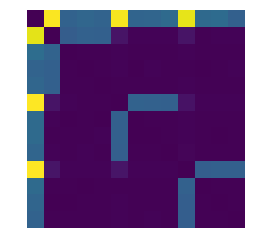

In [9]:
coocurrence_alt = coocurrence - np.diag(np.diag(coocurrence))
niceprint(coocurrence_alt)

fig, ax = plt.subplots()
ax.imshow(coocurrence_alt)
ax.axis('off');

In [10]:
g = nx.Graph()
for i in range(num_topics):
    for j in range(num_topics):
        if i < j:
            # Note: use -coocurrence so that minimum_spanning_tree yields maximum spanning tree
            c = -0.5 * (coocurrence_alt[i, j] + coocurrence_alt[j, i])
            g.add_edge(i, j, weight = c)
tree = nx.algorithms.minimum_spanning_tree(g)
print("Maximum spanning tree:")
print(tree.edges())

Maximum spanning tree:
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12)]


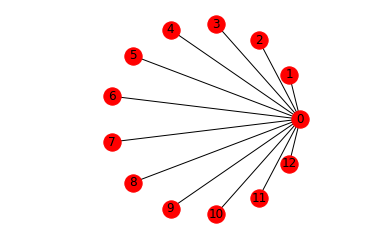

In [11]:
fig, ax = plt.subplots()
nx.draw(tree, pos=nx.circular_layout(tree), ax=ax, with_labels=True)
ax.axis('equal');